# Evaluating Passes

In this Jupyter notebook we will use Wyscout event data to identify players who are good passers of the ball. A logistic regression model is used to classify successful passes, which is then used to predict the most efficient passers of the ball.

In [25]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from os import listdir
%matplotlib inline

In [3]:
#Upload all event files located in the datapath directory and combine them into one df
#Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
datapath = "Wyscout/events/"
event_files = listdir(datapath)
data_raw = pd.DataFrame()
i = 1
for f in event_files:
    with open(datapath + f) as f:
        data = json.load(f)
    data_df = pd.DataFrame(data)
    data_raw = pd.concat([data_raw, data_df], ignore_index=True)
    print('Uploaded event file ' + str(i) + '/7')
    i = i + 1

Uploaded event file 1/7
Uploaded event file 2/7
Uploaded event file 3/7
Uploaded event file 4/7
Uploaded event file 5/7
Uploaded event file 6/7
Uploaded event file 7/7


In [4]:
#Import the players dataset 
with open('Wyscout/players.json') as f:
    data = json.load(f)
players_df = pd.DataFrame(data)

In [8]:
#Identify whether player is a Goalkeeper
players_role = players_df.loc[:,['wyId','role']]
players_role['role'] = players_role['role'].astype(str).str.contains("Goalkeeper").astype(int)
players_role=players_role.rename(columns = {'role':'isGoalkeeper'})
print("Total number of players in data set:", players_role.shape[0])

Total number of players in data set: 3603


In [7]:
#Filter the events dataframe for passes only
passes = data_raw[data_raw['eventId']==8]
#Filter to remove goalkeepers from training set
passes = passes.merge(players_role, left_on='playerId', right_on='wyId', how='left')
passes = passes[passes.isGoalkeeper == 0]
print("Total number of passes in data set:", passes.shape[0])

Total number of passes in data set: 1590254


In [9]:
#Create the training dataset
passes_model_df = pd.DataFrame(columns=['Pass','Y','X','Yend','Xend'])

#Feature Engineering

#Using regular expressions, find completed/incompleted passes and coordinates
passes_model_df["Pass"] = passes['tags'].astype(str).str.contains('1801').astype(int)
coords = passes['positions'].astype(str).str.findall("[0-9]{1,3}")
passes_model_df[['Y','X','Yend','Xend']] = pd.DataFrame(coords.values.tolist(), index=passes_model_df.index)
passes_model_df.isnull().sum()
#Drop the two missing observations
passes_model_df.dropna(inplace=True)
#Change variable types to integer 
passes_model_df.dtypes
passes_model_df = passes_model_df.astype(int)
#Due to the differences in the Wyscout coordinate system, change the x coordinate
passes_model_df['X'] = 100 - passes_model_df['X']
passes_model_df['Xend'] = 100 - passes_model_df['Xend']
#C coordinate
passes_model_df['C'] = np.abs(passes_model_df['Y'] - 50)
#Create indicator variables for the types of pass, such as cross or header
passes_model_df['Cross'] = (passes['subEventId'] == 80).astype(int)
passes_model_df['Hand'] = (passes['subEventId'] == 81).astype(int)
passes_model_df['Head'] = (passes['subEventId'] == 82).astype(int)
passes_model_df['High'] = (passes['subEventId'] == 83).astype(int)
passes_model_df['Launch'] = (passes['subEventId'] == 84).astype(int)
passes_model_df['Simple'] = (passes['subEventId'] == 85).astype(int)
passes_model_df['Smart'] = (passes['subEventId'] == 86).astype(int)
#Calculate distance of pass
x = passes_model_df['X'] * 105/100
y = passes_model_df['C'] * 65/100
passes_model_df['Distance'] = np.sqrt(x**2 + y**2)
#Passing angle with respect to the opposition goal, in radians
a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
passes_model_df['Angle'] = np.where(a < 0, np.pi + a, a)

#Adding even more variables to the model.
squaredX = passes_model_df['X']**2
passes_model_df = passes_model_df.assign(X2=squaredX)
squaredY = passes_model_df['Y']**2
passes_model_df = passes_model_df.assign(Y2=squaredY)
XtimesY = passes_model_df['X'] * passes_model_df['Y']
passes_model_df = passes_model_df.assign(XY=XtimesY)

In [11]:
#Quick eyeball test of training set
print(passes_model_df.head())
print(passes_model_df.shape)

   Pass   Y   X  Yend  Xend   C  Cross  Hand  Head  High  Launch  Simple  \
0     1  51  50    46    69   1      0     0     0     0       0       1   
1     1  46  69    74    32   4      0     0     0     1       0       0   
2     1  40  73    40    66  10      0     0     0     0       0       1   
4     1  86  66    39    68  36      0     0     0     0       0       1   
5     1  39  68    78    68  11      0     0     0     0       0       1   

   Smart   Distance     Angle    X2    Y2    XY  
0      0  52.504024  0.139182  2500  2601  2550  
1      0  72.496638  0.100820  4761  2116  3174  
2      0  76.925110  0.094748  5329  1600  2920  
4      0  73.144036  0.094770  4356  7396  5676  
5      0  71.757108  0.101419  4624  1521  2652  
(1590252, 18)


In [12]:
#Fit the first logistic regression model, where the pass coordinates are the only features   
first_model = smf.glm(formula="Pass ~ X + Y" , data=passes_model_df, family=sm.families.Binomial()).fit()
print(first_model.summary())  

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Pass   No. Observations:              1590252
Model:                            GLM   Df Residuals:                  1590249
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.1992e+05
Date:                Tue, 26 Jan 2021   Deviance:                   1.4398e+06
Time:                        13:11:25   Pearson chi2:                 1.61e+06
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0157      0.006    158.302      0.0

In [13]:
#Fit the improved model, incorporating many more variables   
pass_model = smf.glm(formula="Pass ~ C+X+Y+X2+Y2+Xend+Yend+Cross+Head+High+Launch+Smart+Distance+Angle" , data=passes_model_df, family=sm.families.Binomial()).fit()
print(pass_model.summary())        
#All beta values are significant as p-values are all ~0
#XY has a p-value > 0.05 so does not add more information to the model
#Simple passes also are removed from the final model

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Pass   No. Observations:              1590252
Model:                            GLM   Df Residuals:                  1590237
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.7979e+05
Date:                Tue, 26 Jan 2021   Deviance:                   1.1596e+06
Time:                        13:12:09   Pearson chi2:                 1.52e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0939      0.101    -20.685      0.0

In [15]:
#COMPARISON OF MODEL FIT
#Using AIC
print("Coordinates Model AIC:",first_model.aic)
print("Improved Model AIC:",pass_model.aic)
#The improved model has a lower AIC, which suggests a better fit to the data

Coordinates Model AIC: 1439850.7765743888
Improved Model AIC: 1159600.5754353811


In [16]:
#McFaddens R2
null_model = smf.glm(formula="Pass ~ 1" , data=passes_model_df, family=sm.families.Binomial()).fit()
print("Coordinates Model R2:", 1-first_model.llf/null_model.llf) 
print("Improved Model R2:", 1-pass_model.llf/null_model.llf)
#The final model has a much higher McFaddens R2, suggesting that it is better at explaining the trends in the data

Coordinates Model R2: 0.010505053650904816
Improved Model R2: 0.20311602820254238


In [17]:
#Add predicted values to the dataframe
#FittedxP is defined as the probability of a pass being completed, according to the model
passes_model_df['FittedxP'] = pass_model.fittedvalues
#Add player IDs
passes_model_df['PlayerID'] = passes.playerId
#Add match IDs
passes_model_df['MatchID'] = passes.matchId

print(passes_model_df.head())

   Pass   Y   X  Yend  Xend   C  Cross  Hand  Head  High  ...  Simple  Smart  \
0     1  51  50    46    69   1      0     0     0     0  ...       1      0   
1     1  46  69    74    32   4      0     0     0     1  ...       0      0   
2     1  40  73    40    66  10      0     0     0     0  ...       1      0   
4     1  86  66    39    68  36      0     0     0     0  ...       1      0   
5     1  39  68    78    68  11      0     0     0     0  ...       1      0   

    Distance     Angle    X2    Y2    XY  FittedxP  PlayerID  MatchID  
0  52.504024  0.139182  2500  2601  2550  0.954003    253784  2500686  
1  72.496638  0.100820  4761  2116  3174  0.622602     29474  2500686  
2  76.925110  0.094748  5329  1600  2920  0.939045     56441  2500686  
4  73.144036  0.094770  4356  7396  5676  0.921304     26086  2500686  
5  71.757108  0.101419  4624  1521  2652  0.951560     29474  2500686  

[5 rows x 21 columns]


In [18]:
#Prepare data to find out games played by each player
players_clean = players_df.loc[:,['wyId','firstName','lastName','role']]
players_clean['role'] = players_clean['role'].astype('str')
players_clean['role'].replace(["{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalkeeper'}", "{'code2': 'DF', 'code3': 'DEF', 'name': 'Defender'}", "{'code2': 'MD', 'code3': 'MID', 'name': 'Midfielder'}","{'code2': 'FW', 'code3': 'FWD', 'name': 'Forward'}"], ["Goalkeeper","Defender","Midfielder","Forward"], inplace=True)

#Find number of games played by each player
games_played = passes_model_df.groupby('PlayerID')['MatchID'].nunique()

print(games_played.head())

PlayerID
12     2
36    25
38     6
45     5
48    46
Name: MatchID, dtype: int64


In [19]:
#Summary statistics by player 
sumStats = passes_model_df.groupby('PlayerID', as_index=False).mean()
playersSummary = sumStats.loc[:,['PlayerID', 'Pass', 'FittedxP']]
playersSummary['Difference'] = playersSummary['Pass'] - playersSummary['FittedxP']
playersSummary['PercentileRank'] = playersSummary['Difference'].rank(pct=True)
playersSummary = playersSummary.merge(players_clean, left_on='PlayerID', right_on='wyId', how='left')
#Merge games played into 
playersSummary = playersSummary.merge(games_played, left_on='PlayerID', right_index=True, how='left')

print(playersSummary.head())

   PlayerID      Pass  FittedxP  Difference  PercentileRank  wyId  \
0        12  0.765625  0.804925   -0.039300        0.260372    12   
1        36  0.890393  0.841187    0.049206        0.928112    36   
2        38  0.857143  0.806146    0.050997        0.930615    38   
3        45  0.812030  0.802139    0.009891        0.654506    45   
4        48  0.887255  0.852690    0.034565        0.855866    48   

        firstName      lastName      role  MatchID  
0  Kenneth Josiah        Omeruo  Defender        2  
1            Toby  Alderweireld  Defender       25  
2           Daley         Blind  Defender        6  
3         Gregory  van der Wiel  Defender        5  
4             Jan    Vertonghen  Defender       46  


In [20]:
#Filter for players with over 25 games played
over25games = playersSummary[playersSummary.MatchID >=25].sort_values(by='Difference', ascending=False)
topDef = over25games[over25games['role']=='Defender'].head(3)
topMid = over25games[over25games['role']=='Midfielder'].head(3)
topFor = over25games[over25games['role']=='Forward'].head(3)
topPlayers = pd.concat([topDef, topMid, topFor], ignore_index=True)
topPlayers['Player'] = topPlayers.firstName + ' ' + topPlayers.lastName
topPlayers = topPlayers[['role','Player','FittedxP','Pass','Difference']]
topPlayers=topPlayers.rename(columns = {'role':'Position','FittedxP':'Expected Pass Completion (%)','Pass':'Actual Pass Completion (%)','Difference':'Gain(%)'})
#topPlayers dataframe is used for the table plot in the report
#It shows the top 3 players ranked by the model in each position
print(topPlayers)

     Position                          Player  Expected Pass Completion (%)  \
0    Defender                  Joshua Kimmich                      0.802430   
1    Defender  \u00c1lvaro Odriozola Arzallus                      0.792057   
2    Defender        Sergio Ramos Garc\u00eda                      0.868971   
3  Midfielder                    Fabian Delph                      0.875987   
4  Midfielder                      Toni Kroos                      0.875237   
5  Midfielder   Juan Guillermo Cuadrado Bello                      0.805128   
6     Forward                  Kingsley Coman                      0.778106   
7     Forward     Lucas V\u00e1zquez Iglesias                      0.793317   
8     Forward                   Diego Perotti                      0.788021   

   Actual Pass Completion (%)   Gain(%)  
0                    0.869159  0.066729  
1                    0.850454  0.058397  
2                    0.927344  0.058373  
3                    0.939376  0.063389  

## Joshua Kimmich Analysis

In [21]:
#Dataframe containing all passes made by Joshua Kimmich
kimmich_id = 224593
kimmich_df = passes_model_df[passes_model_df.PlayerID == kimmich_id]
#Create dataframe of all events by defenders not including Kimmich for comparison (defenders)
players_role = players_df.loc[:,['wyId','role']]
players_role['role'] = players_role['role'].astype(str).str.contains("Defender").astype(int)
players_role=players_role.rename(columns = {'role':'isDefender'})
defenders = passes_model_df.copy()
defenders = defenders.merge(players_role, left_on='PlayerID', right_on='wyId', how='left')
defenders = defenders[defenders.isDefender==1]
print(defenders.head())

   Pass   Y   X  Yend  Xend   C  Cross  Hand  Head  High  ...   Distance  \
1     1  46  69    74    32   4      0     0     0     1  ...  72.496638   
3     1  86  66    39    68  36      0     0     0     0  ...  73.144036   
4     1  39  68    78    68  11      0     0     0     0  ...  71.757108   
5     1  92  83    99    73  42      0     0     0     0  ...  91.325859   
6     1  99  73    89    71  49      0     0     0     0  ...  83.003885   

      Angle    X2    Y2    XY  FittedxP  PlayerID  MatchID   wyId  isDefender  
1  0.100820  4761  2116  3174  0.622602     29474  2500686  29474           1  
3  0.094770  4356  7396  5676  0.921304     26086  2500686  26086           1  
4  0.101419  4624  1521  2652  0.951560     29474  2500686  29474           1  
5  0.076461  6889  8464  7636  0.867658     26086  2500686  26086           1  
6  0.081416  5329  9801  7227  0.865967     26265  2500686  26265           1  

[5 rows x 23 columns]


In [23]:
#1.9% of Kimmich's passes are 'smart', compared to 0.7% from other defenders
print("Kimmich Smart Passes:", kimmich_df.Smart.sum()/kimmich_df.shape[0])
print("Defenders Smart Passes:", defenders.Smart.sum()/defenders.shape[0])

Kimmich Smart Passes: 0.019116397621070518
Defenders Smart Passes: 0.007460657522936433


In [24]:
#Final third pass entries 
#Final 3rd entries are all passes such that X < 67 and Xend >= 67

#7.73% of passes entered the final third
a = kimmich_df[kimmich_df.X < 67]
final_3_entry = a[a.Xend >= 67]
print("Kimmich Final 3rd Entries:", final_3_entry.shape[0]/kimmich_df.shape[0]*100)
#Compared to 5.3% of the average defender
b = defenders[defenders.X < 67]
final_3_entry_rest = b[b.Xend >= 67]
print("Defenders Final 3rd Entries:", final_3_entry_rest.shape[0]/defenders.shape[0]*100)

Kimmich Final 3rd Entries: 7.731520815632965
Defenders Final 3rd Entries: 5.31470422856004


In [28]:
#Visualise smart passes and final third entries using a swarm plot, highlighting Kimmich
#Using defenders dataframe, create column for total smart passes and total passes per player

passes_played = defenders.groupby("PlayerID", as_index=False)['Pass'].count()
passes_played=passes_played.rename(columns = {'Pass':'PassesCompleted'})
smart_passes = defenders.groupby("PlayerID", as_index=False)['Smart'].sum()
smart_passes=smart_passes.rename(columns = {'Smart':'SmartPassesCompleted'})

#Analysis of final third entries
d = defenders[defenders.X < 67]
def_final_3_entry = d[d.Xend >= 67]
def_final_3_entry = def_final_3_entry.groupby("PlayerID", as_index=False)['Pass'].count()
def_final_3_entry=def_final_3_entry.rename(columns = {'Pass':'FinalThirdEntries'})

defenders_summary = passes_played.merge(smart_passes, left_on='PlayerID', right_on='PlayerID', how='left')
defenders_summary = defenders_summary.merge(def_final_3_entry, left_on='PlayerID', right_on='PlayerID', how='left')
defenders_summary['PercSmart'] = defenders_summary['SmartPassesCompleted'] / defenders_summary['PassesCompleted'] * 100
defenders_summary['FinalThirdEntries'] = defenders_summary['FinalThirdEntries'].fillna(0)
defenders_summary['PercFinalThirdEntries'] = defenders_summary['FinalThirdEntries'] / defenders_summary['PassesCompleted'] * 100

#Filter for defenders with minimum 1000 passes
def_sum_filt = defenders_summary.loc[defenders_summary.PassesCompleted > 1000,:].copy()
def_sum_filt['Kimmich'] = np.where(def_sum_filt['PlayerID']==kimmich_id, 1, 0)
def_sum_filt = def_sum_filt[def_sum_filt['Kimmich'] == 0]

print(def_sum_filt.head())

   PlayerID  PassesCompleted  SmartPassesCompleted  FinalThirdEntries  \
1        36             1551                     7               75.0   
4        48             2856                    21              137.0   
5        74             1130                     5               45.0   
6        77             1416                     3               50.0   
7       102             2070                     3               83.0   

   PercSmart  PercFinalThirdEntries  Kimmich  
1   0.451322               4.835590        0  
4   0.735294               4.796919        0  
5   0.442478               3.982301        0  
6   0.211864               3.531073        0  
7   0.144928               4.009662        0  


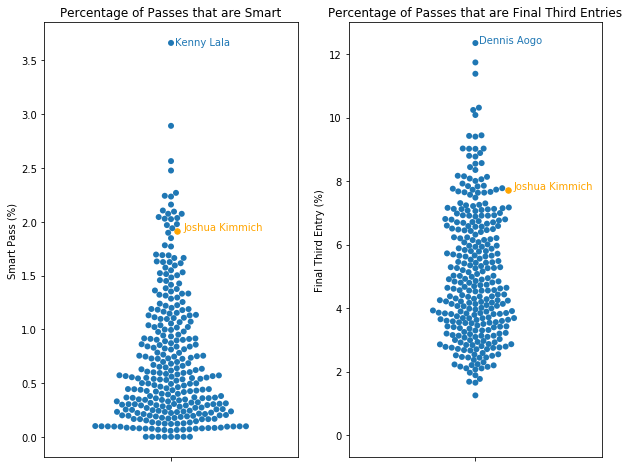

In [29]:
#Swarm plot of Percentage Smart Passes
fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(1, 2, 1)
swarm_smart = sns.swarmplot(y = "PercSmart", data=def_sum_filt, size = 6)
plt.scatter(0.022, 1.91164, marker='o', s=30, color="orange")
plt.annotate("Joshua Kimmich", (0.05, 1.92), color="orange")
plt.annotate("Kenny Lala", (0.015, 3.64), color="#1F77B4")
plt.title("Percentage of Passes that are Smart")
plt.ylabel("Smart Pass (%)")

plt.subplot(1, 2, 2)
swarm_smart = sns.swarmplot(y = "PercFinalThirdEntries", data=def_sum_filt, size = 6)
plt.scatter(0.13, 7.73152, marker='o', s=30, color="orange")
plt.annotate("Joshua Kimmich", (0.15, 7.75), color="orange")
plt.annotate("Dennis Aogo", (0.015, 12.33), color="#1F77B4")
plt.ylim(-0.7, 13)
plt.title("Percentage of Passes that are Final Third Entries")
plt.ylabel("Final Third Entry (%)")
plt.show()

Matplotlib is building the font cache using fc-list. This may take a moment.


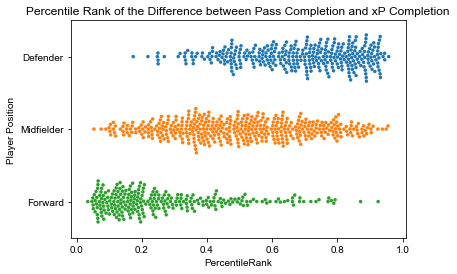

In [30]:
fig, ax = plt.subplots()
sns.set_style(style="whitegrid")
swarm = sns.swarmplot(x="PercentileRank", y="role", data=over25games, size=3.5)
swarm.set_title("Percentile Rank of the Difference between Pass Completion and xP Completion")
swarm.set_ylabel("Player Position")
fig=swarm.get_figure()
plt.show()